# 09.00 Classification vs Regression

We have been debunking the common categorization of machine learning for a while now.
We saw how clustering is most often used as semi-supervised learning and not
completely supervised.
This is because for the vast majority of practical cases we need at least some
labels in order to evaluate how the clustering model is performing.
The (outdated) categorization looks as follows.

- Supervised Learning
  + Classification
  + Regression
- Unsupervised Learning
  + Dimensionality Reduction
  + Clustering

The real focus of differentiation of machine learning is the
linearity and non-linearity of the problems faced.
We also had a look that since the reducibility of the entire world
into first principles is not possible,
i.e. that *reductionism* cannot fully explain the world we live in,
that linear problems are just a small fractions of problems we face.

Now we will focus on supervised learning an break the separation there.

How is *classification* different from *regression*?
Both techniques are a form of supervised learning,
i.e. require training data to have some kind of labels or values which represent the desired output.
It turns out that most classification methods can be used to perform regression
and most regression methods can be used to perform classification.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d
plt.style.use('seaborn-talk')

### Logistic Regression

Imagine that we can construct a continuous function $f$ from a classification problem,
and then say that values below some value of $f(\vec{x}) = y_{decision}$ are from one class
and above this value are from the other class.
That is one common way of turning regression into binary classification (only two classes),
yet points with values very close to $y_{decision}$ would be often misclassified.

Instead, we can say that points with values close to $y_{decision}$ have a good probability
of being from either of the classes (with a little higher probability for the class on which
side of $y_{decision}$ the point is).
Points away from $y_{decision}$ will then have a big probability of being of one of the classes
and zero or almost zero probability of being from the other class.
This is what logical regression performs.
And several other classification techniques also perform this trick
with a **decision function** below the hood.

People say that a stew needs to be cooked for a long time to be good.
Let's see if we can classify stews based on their cooking time
and how the people who ate them liked them.
Here we have the cooking times I did try when cooking a stew
and whether I could confirm later that the person eating it
found it palatable.

![Stew](sl-stew.svg)

<div style="text-align:right;"><sup>sl-stew.svg</sup></div>

In [2]:
df = pd.DataFrame({
    'cooking time (h)': [0.2, 0.5, 0.6, 0.7, 1.0, 1.2, 1.3, 1.5, 1.9, 2.0, 2.5, 3.0, 3.7, 4.5],
    'satisfied eater':  [  0,   0,   0,   1,   0,   1,   0,   0,   1,   1,   1,   1,   1,   1]})
df

,cooking time (h),satisfied eater
0,0.2,0
1,0.5,0
2,0.6,0
3,0.7,1
4,1.0,0
5,1.2,1
6,1.3,0
7,1.5,0
8,1.9,1
9,2.0,1


We can see that it is more likely that a better cooked steak leaves a satisfied eater.
Yet where exactly is the boundary defined by this data is slightly more complicated.
If the measures were equally distributed we could take the mean of the classes on a scaled space.
But even that could account badly for people who,
out of politeness, lied that the stew was good.

An easier way is to fit a model, and we will try  logistic regression.
We will come back to the `C=` argument right away.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

model = LogisticRegression(C=1.5)
X = df['cooking time (h)'].values[:, np.newaxis]
y = df['satisfied eater']
cross_val_score(model, X, y, cv=3)

array([0.6, 1. , 0.5])

The cross validation is not overly good but anything above $0.5$
should be good enough for such a tiny dataset.

What we are fitting is a continuous *logit* function that attempts to find
a good measure of the positive class (satisfied).

$$
\min_{w,b} C \sum_{i=1}^N log(exp(-y_i(x_i^T w + b)) + 1) + \frac{\|w\|_2^2}{2}
$$

This produces a value between 0 and 1 for every sample in the dataset
and can be steered by the parameters inside the $w$ vector and the $C$ hyperparameter.
$w$ contains a parameter for every feature.
$C$ on the other hand is a *sensitivity* hyperparameter.
A very high $C$ will make the logit function never leave a sample
on the wrong side of the decision value, yet this may not converge.
A very small $C$ will make the solution tend to the mean for all samples.
As with most hyperparameters one should tune $C$ to the given problem.

The regularization parameter (on the right hand side) has no
$\alpha$ hyperparameter multiplying it as we had in ridge an lasso
regressions.
In the equation above we see `L2` but `L1` and elastic net can also be used.
The important fact is that since we are only interested in minimizing
the value of the function it does not matter what the actual values are,
the minimums will be in the same places after all.
Since there is no hyperparameter multiplying the regularization parameter
but there is a hyperparameter ($C$) multiplying everything else in the function
to be optimized, the $C$ hyperparameter works as an inverse regularization.
A high $C$ means a non-regularized models,
a tiny $C$ means a highly regularized model.

Let's use our trained model to check the probability of someone
being satisfied by the stew cooked by the following times.

In [4]:
model.fit(X, y)
model.predict([[0.3], [2.6]]), model.predict_proba([[0.3], [2.6]])

(array([0, 1]),
 array([[0.80690163, 0.19309837],
        [0.14256094, 0.85743906]]))

The `predict` method gives us the class as expected.
But the `predict_proba` gives out two numbers per sample.
These two numbers are the probabilities to the negative and the positive classes, respectively.

The negative class, in a binary classification is just $1 - y$ of the positive class.
We can see it better if we plot both probabilities at the same time.

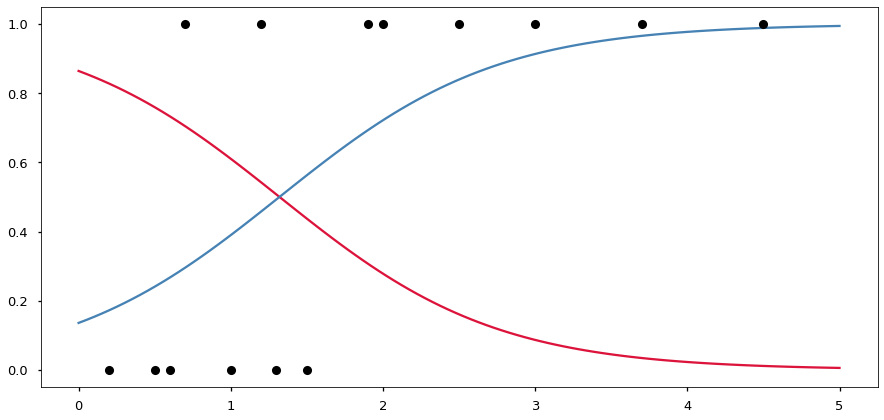

In [5]:
xfit = np.linspace(0, 5, 100)
yfit = model.predict_proba(xfit[:, np.newaxis])
fig, ax = plt.subplots(1, figsize=(15, 7))
ax.plot(xfit, yfit[:, 0], color='crimson')
ax.plot(xfit, yfit[:, 1], color='steelblue')
ax.plot(X, y, 'o', color='black');

The blue line is the decision function produced by the Logistic Regression classifier.
Whilst the red line would be the decision function had we reversed the classes.

Using *logit* function for classification is actually much more common than for regression.
Since logistic regression classification provides probabilities it is
a good model to explain the classification performed.
The probabilities that are close to $0.5$ are the points where
the decision function is close to $0.5$.
In the graph is is where the blue and red lines cross,
around this point the classifier is not very confident what the class should be.

### Regression using KNN

On the other hand we can also use a classification technique to perform a regression.
When we count the neighbors in the $k$ nearest neighbors algorithm for classification
we take the class of the majority of neighbors.
But what if, instead of classes we have real values and we want a regression?
We could simply take the mean of all the neighbors.
And this is exactly how a regressor based on KNN works.

Onto a problem: The foundation depth of a crane depends on what lift it will need to carry,
which in turn depends on the maximum weight and size (in the biggest dimension) of the load it may carry.
Let's try to estimate that foundation depth.
Here are some samples of foundation depth against their crane features.

![Crane](sl-crane.svg)

<div style="text-align:right;"><sup>sl-crane.svg</sup></div>

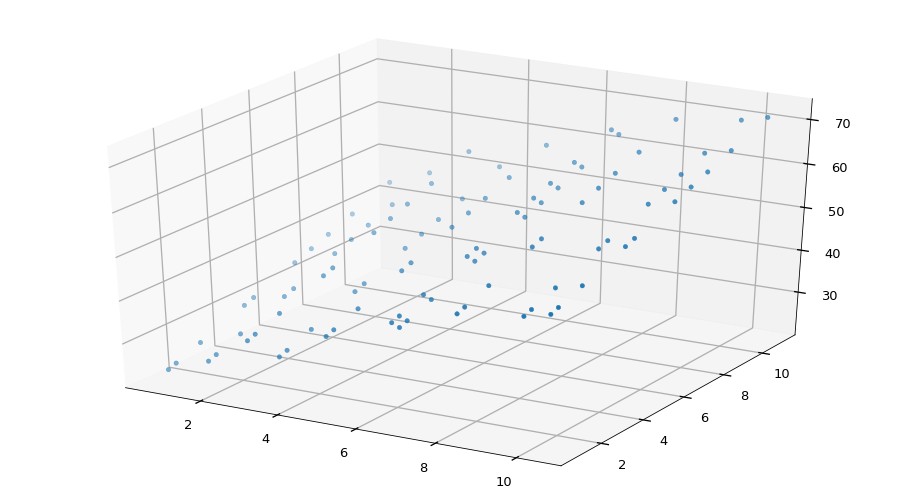

In [6]:
weight = np.linspace(0, 10, 10) + np.random.rand(10)
size = np.linspace(0, 10, 10) + np.random.rand(10)
w, s = np.meshgrid(weight, size)
lift_foundation = w*3 + s*2 + 17 + 7*np.random.rand(10)
X = np.c_[w.reshape(-1), s.reshape(-1)]
y = lift_foundation.reshape(-1)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(w, s, lift_foundation);

Since we are working in three dimensions we use a mesh grid.
But we also reshape all the data into simple `X` and `y`
arrays for samples and expected values.

This is a set with two features, and we can see an almost-plane forming,
We will estimate the plane based on data with a `KNeighborsRegressor`.
Before we used the $R2$ measure to score the regressions,
yet the $R2$ measure is particularly badly descriptive with KNN regressions.
This is because the regression uses means to explain large regions
and the variance of data within those regions is small.
But $R2$ expects a function that passes through the test data points,
and not a function that finds the best mean value close to the the test points.
Instead we will use plain explained variance to score our model.

In [7]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

model = KNeighborsRegressor(n_neighbors=3)
grid = GridSearchCV(model, {'n_neighbors': [3, 4, 5, 6, 7]}, scoring='explained_variance', cv=5)
grid.fit(X, y)
grid.best_score_

0.9467639742591365

A pretty reasonable score.

The grid search found the best hyperparameters
from the ones we have given.
The randomness in the data creation above requires
us to search for the hyperparameters each time.
The value chosen for `n_neighbors=` can be checked by printing the model out.

In [8]:
grid.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='uniform')

We can be confident in our model due to the quite reasonable score.
One thing we should do is try to visualize how this model builds
the values it predicts.
We build a visualization by predicting lots of points with this model.

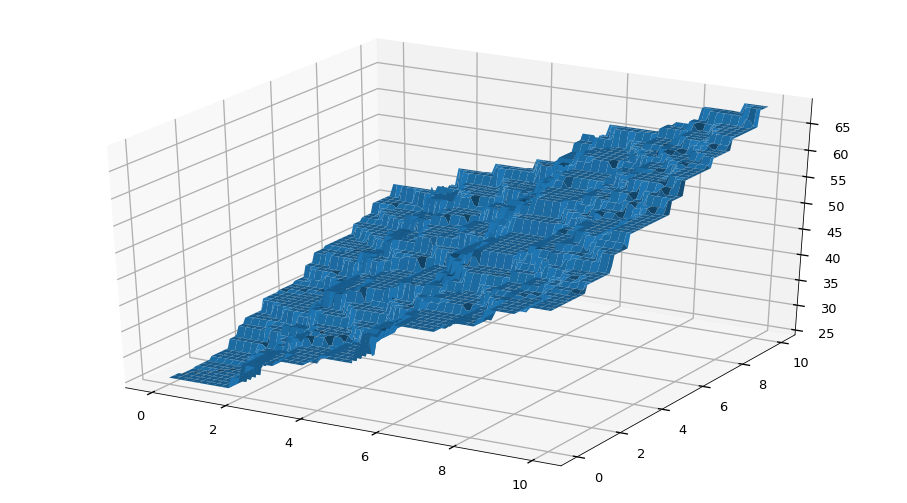

In [9]:
xmesh, ymesh = np.meshgrid(np.linspace(0, 10, 100), np.linspace(0, 10, 100))
xfit = np.dstack([xmesh, ymesh]).reshape(10000, 2)
model = grid.best_estimator_
yfit = model.predict(xfit)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xmesh, ymesh, yfit.reshape(100, 100));

Just like we can make areas where a certain class holds we can make areas
where a certain continuous value holds.
In simple words, the classification and regression problems are always related.
The techniques for classification and/or regression try to
either build a *decision function* across data points,
or divide the search space into *specific areas* which hold a label or value.

## Types of Machine Learning Models

We saw that we can divide machine learning problems/models in four categories:

- Classification
- Regression
- Dimensionality Reduction
- Clustering

We also saw that the line between *classification* and *regression* is pretty thin,
i.e. that these models only differ in how they present their outputs.
Yet, there are even thinner divisions between other forms of machine learning techniques.
Some other types for machine learning problems you may see out there follow.
Concepts we have not yet covered are needed to fully describe these methods,
but worry not as we will cover a good deal of these concepts.

- *Anomaly detection* is a binary classification problem where *normal*
  is one of the classes and *abnormal* the other.
  Tuning between precision and recall for these classes is often automated in a way that
  it is easy to change an abnormal activity into a normal sample upon human inspection.

- *Association Rule Learning* is a clustering problem where we use several
  different distance measures and deterministic ways of defining clusters.
  In other words, it is a clustering technique simplified to a level which
  can be easily explained.
  Some forms of hierarchical clustering can be thought as rule learners.

- *Reinforcement Learning* is a non-linear online learning classification/regression
  technique with a *variable learning rate*.
  This attempt to reuse knowledge obtained from one task into learning another task.
  Reinforcement learning is what we often consider robot-AI, and, to be fair,
  is quite popular in robot development.

Finally there are also **genetic algorithms** and **swarm intelligence**
which are completely different techniques.
The mathematical foundation to the convergence of genetic algorithms
or swarm intelligence are not developed.
Both techniques take analogies from nature and use them to iteratively build and tune ML models.
Experimental techniques proved that both techniques
work but their application to new problems is tricky to develop.
In essence, the use of these algorithms in a practical manner is viable,
and even very successful, on specific problems.
But the mathematical formulation of the techniques is next to non-existent.
This may change in the following years (perhaps decades),
if you want a not extensively explored field to work in there's your chance.

Even that is not all.
Another form of machine learning use to solve problems is not to
use a single model but to use several models at once,
and then combine the answers from all those models together.